In [1]:
# Imports

from pathlib import Path
import os
import pandas as pd
import numpy as np
import importlib.util
import time
import matplotlib.pyplot as plt

In [2]:
# Time window
START_DATE = '2025-01-01'
END_DATE = '2025-07-01'

# Simulation controls
N_SIMULATIONS = 1000000   
TOP_K_PLOTS = 10        

# Risk free rate (annual)
RF_ANNUAL = 0.04

# Rebalancing mode, 'static' or 'random_daily'
REBALANCE_MODE = 'random_daily'

# Outputs
OUT_DIR = Path.cwd()
(OUT_DIR).mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f"Rebalance mode: {REBALANCE_MODE}")

Output directory: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc
Rebalance mode: random_daily


In [3]:
# Locate data dir
from pathlib import Path
data_dir = Path.cwd().parent.parent / 'data'
prices_csv = data_dir / 'etf_prices.csv'
prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)

# Slice by window and compute returns
prices = prices.loc[START_DATE:END_DATE]
if prices.empty:
    raise ValueError("No price data in the selected window.")

returns = prices.pct_change().dropna()
asset_list = returns.columns.tolist()
print(f"Assets: {len(asset_list)} -> {asset_list}")
print(f"Window: {returns.index.min().date()} -> {returns.index.max().date()} (n={len(returns)})")

Assets: 10 -> ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'VNQ', 'TLT', 'IEF', 'GLD', 'USO']
Window: 2025-01-03 -> 2025-07-01 (n=122)


In [4]:
TRADING_DAYS = 252

def max_drawdown(series: pd.Series) -> float:
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    return dd.min()

def portfolio_metrics(port_ret: pd.Series, rf_annual: float = 0.0) -> dict:
    if len(port_ret) == 0:
        return {"cagr": np.nan, "vol": np.nan, "sharpe": np.nan, "mdd": np.nan}
    # CAGR
    wealth = (1 + port_ret).cumprod()
    n_years = len(port_ret) / TRADING_DAYS
    cagr = wealth.iloc[-1] ** (1 / n_years) - 1 if n_years > 0 else np.nan
    # Volatility (annualized)
    vol = port_ret.std(ddof=1) * np.sqrt(TRADING_DAYS)
    # Sharpe (excess return over rf)
    rf_daily = rf_annual / TRADING_DAYS
    excess = port_ret - rf_daily
    sharpe = (excess.mean() * TRADING_DAYS) / vol if vol > 0 else np.nan
    # Max drawdown
    mdd = max_drawdown(port_ret)
    return {"cagr": cagr, "vol": vol, "sharpe": sharpe, "mdd": mdd}

def random_weights(n_assets: int) -> np.ndarray:
    w = np.random.rand(n_assets)
    s = w.sum()
    return (w / s) if s > 0 else np.ones(n_assets) / n_assets

def simulate_portfolios(returns: pd.DataFrame, n_sims: int, rf_annual: float = 0.0, mode: str = 'static') -> tuple[pd.DataFrame, pd.DataFrame]:
    n_assets = returns.shape[1]
    n_days = returns.shape[0]
    all_weights = np.zeros((n_sims, n_assets))
    metrics = []

    if mode == 'static':
        for i in range(n_sims):
            w = random_weights(n_assets)
            all_weights[i, :] = w
            port_ret = (returns.values @ w)
            port_ret = pd.Series(port_ret, index=returns.index)
            m = portfolio_metrics(port_ret, rf_annual=rf_annual)
            m["final_wealth"] = float((1 + port_ret).cumprod().iloc[-1])
            m["idx"] = i
            metrics.append(m)
    elif mode == 'random_daily':
        # For random_daily, weights change every day; final weights snapshot is the last day's weights
        for i in range(n_sims):
            daily_w = np.apply_along_axis(lambda _: random_weights(n_assets), 1, np.zeros((n_days, n_assets)))
            # Compute daily portfolio returns as row-wise dot of returns and weights
            port_ret_vals = (returns.values * daily_w).sum(axis=1)
            port_ret = pd.Series(port_ret_vals, index=returns.index)
            m = portfolio_metrics(port_ret, rf_annual=rf_annual)
            m["final_wealth"] = float((1 + port_ret).cumprod().iloc[-1])
            m["idx"] = i
            metrics.append(m)
            all_weights[i, :] = daily_w[-1]
    else:
        raise ValueError("Unsupported mode. Use 'static' or 'random_daily'.")

    metrics_df = pd.DataFrame(metrics)
    weights_df = pd.DataFrame(all_weights, columns=returns.columns)
    return metrics_df, weights_df

In [5]:
# Run simulation

start_t = time.time()
metrics_df, weights_df = simulate_portfolios(returns, N_SIMULATIONS, rf_annual=RF_ANNUAL, mode=REBALANCE_MODE)
elapsed = time.time() - start_t

# Rank by Sharpe, then by final wealth

metrics_df = metrics_df.sort_values(["sharpe", "final_wealth"], ascending=[False, False]).reset_index(drop=True)
print(f"Simulations: {N_SIMULATIONS} in {elapsed:.2f}s | Mode: {REBALANCE_MODE}")
print("Top 10 portfolios (Sharpe):")
print(metrics_df.head(10))


Simulations: 1000000 in 785.86s | Mode: random_daily
Top 10 portfolios (Sharpe):
       cagr       vol    sharpe       mdd  final_wealth     idx
0  0.487885  0.149526  2.465136 -0.079025      1.212120  469203
1  0.465692  0.147697  2.392179 -0.079116      1.203333  541563
2  0.482668  0.155047  2.359905 -0.088807      1.210060  378882
3  0.407149  0.136512  2.278199 -0.084766      1.179819  353845
4  0.408344  0.142028  2.200673 -0.082126      1.180304  785021
5  0.406993  0.144354  2.160921 -0.100297      1.179756   61955
6  0.410821  0.145888  2.158189 -0.083214      1.181309   80388
7  0.441192  0.156512  2.157652 -0.086971      1.193553   34362
8  0.440147  0.156282  2.156391 -0.101745      1.193133  500397
9  0.398336  0.142143  2.148832 -0.085749      1.176236  422259


In [6]:
# Top percentile summary

cut = int(np.ceil(len(metrics_df) * (1 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {1}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (0.1 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {0.1}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (0.01 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {0.01}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (50 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {50}% summary over {cut} portfolios:")
print(summary)


Top 1% summary over 10000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.321369  0.155674  1.610096 -0.102647      1.144389
max   0.487885       NaN  2.465136       NaN      1.212120
min        NaN  0.129341       NaN -0.141019           NaN

Top 0.1% summary over 1000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.365008  0.154364  1.833292 -0.097780      1.162536
max   0.487885       NaN  2.465136       NaN      1.212120
min        NaN  0.131164       NaN -0.124381           NaN

Top 0.01% summary over 100 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.402764  0.152531  2.032067 -0.093827       1.17798
max   0.487885       NaN  2.465136       NaN       1.21212
min        NaN  0.135014       NaN -0.117522           NaN

Top 50% summary over 500000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.210318  0.158211  1.030120 -0.115516      1.096696
max   0.487885

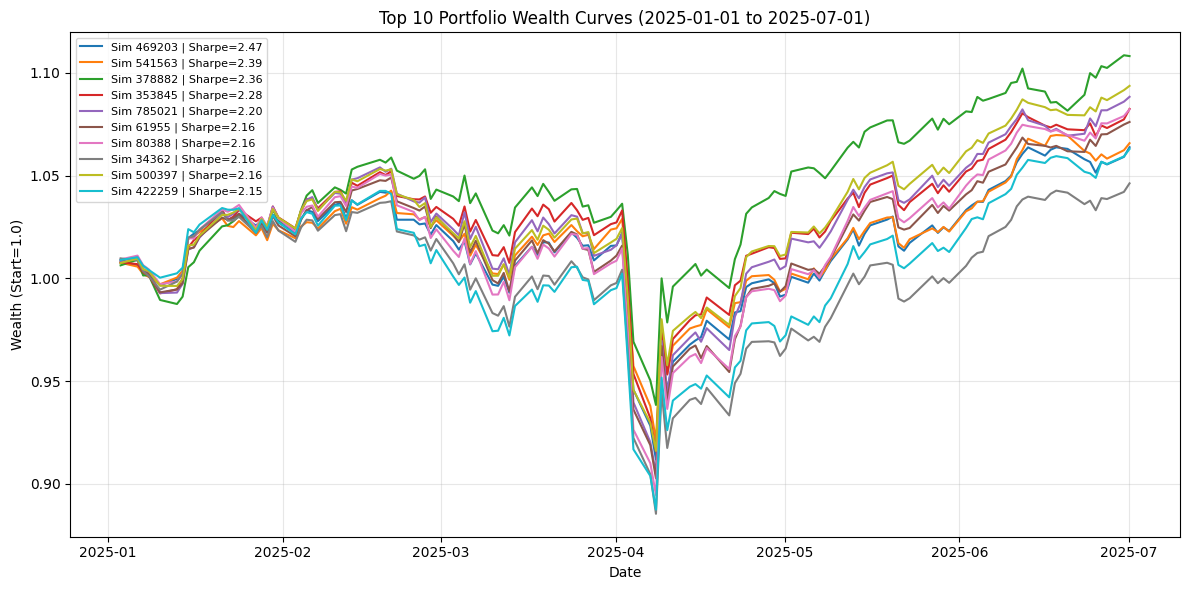

In [7]:
# Plot wealth curves for top portfolios

k = min(TOP_K_PLOTS, len(metrics_df))
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(k):
    sim_idx = int(metrics_df.loc[i, 'idx'])
    w = weights_df.iloc[sim_idx].values
    port_ret = pd.Series(returns.values @ w, index=returns.index)
    wealth = (1 + port_ret).cumprod()
    ax.plot(wealth, label=f"Sim {sim_idx} | Sharpe={metrics_df.loc[i,'sharpe']:.2f}")

ax.set_title(f"Top {k} Portfolio Wealth Curves ({START_DATE} to {END_DATE})")
ax.set_xlabel("Date")
ax.set_ylabel("Wealth (Start=1.0)")
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig(OUT_DIR / 'mc_wealth_topK.png', dpi=200, bbox_inches='tight')
plt.show()

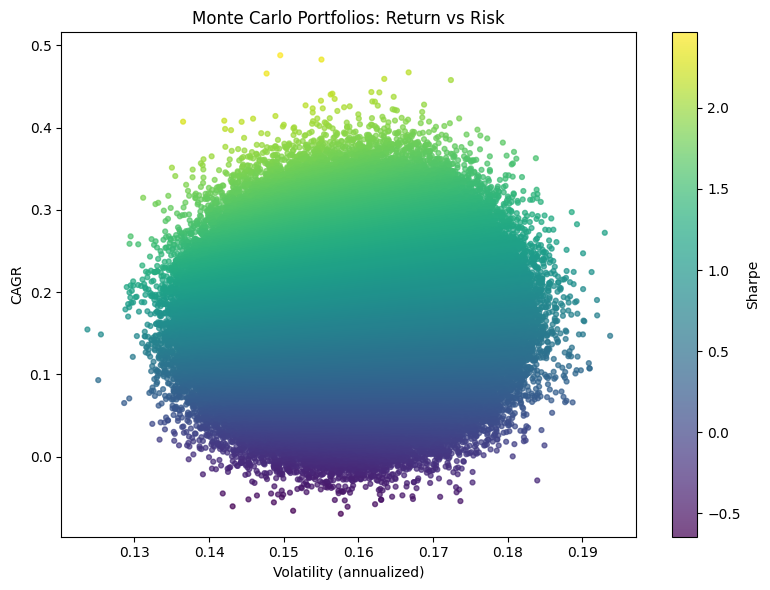

In [8]:
# Scatter: CAGR vs Volatility (colored by Sharpe)
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(metrics_df['vol'], metrics_df['cagr'], c=metrics_df['sharpe'], cmap='viridis', s=12, alpha=0.7)
ax.set_xlabel('Volatility (annualized)')
ax.set_ylabel('CAGR')
ax.set_title('Monte Carlo Portfolios: Return vs Risk')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('Sharpe')
plt.tight_layout()
plt.savefig(OUT_DIR / 'mc_scatter_return_vs_risk.png', dpi=200, bbox_inches='tight')
plt.show()

In [9]:
# Save a single combined CSV with metrics, weights, and flags

n = len(metrics_df)
k = min(TOP_K_PLOTS, n)
cut = int(np.ceil(n * (TOP_PERCENTILE / 100.0)))
cut = max(cut, 1)

# Align weights to the sorted metrics order using original simulation index
weights_sorted = weights_df.iloc[metrics_df['idx'].astype(int)].reset_index(drop=True)
combined = pd.concat([metrics_df.reset_index(drop=True), weights_sorted], axis=1)

# Add flags and metadata
combined.insert(0, 'rank', range(1, n + 1))
combined['is_topK'] = combined['rank'] <= k
combined['is_top_percentile'] = combined['rank'] <= cut
combined['mode'] = REBALANCE_MODE
combined['start_date'] = START_DATE
combined['end_date'] = END_DATE
combined['rf_annual'] = RF_ANNUAL

out_csv = OUT_DIR / 'mc_results.csv'
combined.to_csv(out_csv, index=False)
print(f"Saved single CSV: {out_csv}")

# Keep plots already saved above
print("Plots saved:", OUT_DIR / 'mc_wealth_topK.png', ',', OUT_DIR / 'mc_scatter_return_vs_risk.png')

NameError: name 'TOP_PERCENTILE' is not defined